In [128]:
import pandas as pd
import numpy as np
import pylab
import scipy.stats as stats
import matplotlib.pyplot as plt
import datetime as datetime

plt.style.use('default')

In [129]:
#load the data
df_users = pd.read_csv('./data/users.csv')
df_users.head(5)

,nbr_ratings,nbr_reviews,user_id,user_name,joined,location
0,7820,465,nmann08.184925,nmann08,1.199704e+09,"United States, Washington"
1,2521,2504,stjamesgate.163714,StJamesGate,1.191838e+09,"United States, New York"
2,1797,1143,mdagnew.19527,mdagnew,1.116410e+09,Northern Ireland
3,31,31,helloloser12345.10867,helloloser12345,1.101380e+09,Northern Ireland
4,604,604,cypressbob.3708,cypressbob,1.069326e+09,Northern Ireland


In [130]:
# The features that characterize users are self-explanatory:
# nbr_ratings : the number of ratings a user has given
# nbr_reviews : the number of reviews a user has given
# user_id : internal database representation BeerAdvocate chose for their users
# user_name : the username chosen by the user on the website
# joined : the date when the users joined the website, expressed as a Unix timestamp
# location : where the users comes from

# The difference between a review and a rating:
# A review is a rating which the user decided to elaborate using a small text.

# Users have the choice to comment their ratings: if they decide to do so, they are doing a review.
# If they do not comment their rating, then BeerAdvocate refers to it as a rating.
# Notice that every review is a rating, but not vice versa.

In [131]:
total_nb_users = df_users.user_name.nunique()
print(total_nb_users)
df_users[df_users.nbr_ratings == 0].user_name.nunique()

153703


0

In [132]:
#We can see that all of the users in the database gave at least 1 ratings
df_users = df_users[df_users.nbr_ratings > 0]
print(df_users.user_name.nunique() / total_nb_users)
#How many people from the US?
df_us_users = df_users[df_users.location.str.contains('United States', na = False)]
number_us_users = df_us_users.user_name.nunique()
print(number_us_users)
number_us_users/total_nb_users
# -> 74% of the people come from the United States of America.


1.0
113222


0.7366284327566801

In [133]:
#Around all 50 states of America. -> distribution by state?
df_us_users.location.nunique()

50

In [134]:
# Let us now focus on the number of ratings done by US users.
# With the help of a QQ-Plot, we can get a first grasp of the data distribution

((array([6.12196445e-06, 1.48601174e-05, 2.36923870e-05, ...,
         1.06503686e+01, 1.11168370e+01, 1.20036306e+01]),
  array([    1,     1,     1, ..., 10180, 10302, 10360])),
 (195.69569474354265, -131.18281545867006, 0.7122689783793736))

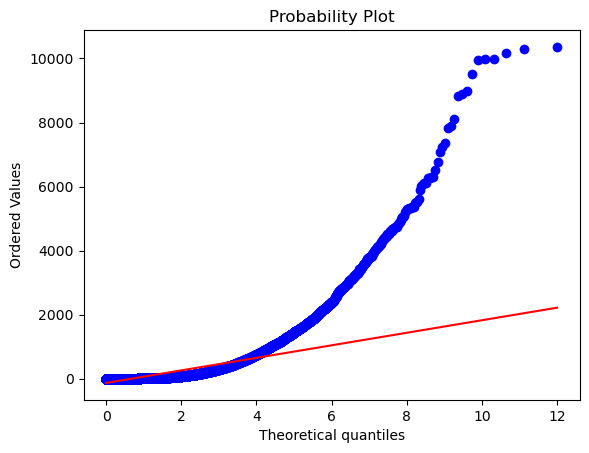

In [135]:
stats.probplot(df_us_users.nbr_ratings, dist = "expon", plot=pylab)

In [136]:
# The distribution looks extremely heavy tailed. 
# Looking at some simple statistics:

In [137]:
nb_ratings_us_users = df_us_users.nbr_ratings.sum()
print(nb_ratings_us_users)
df_us_users['nbr_ratings'].describe()

7303870


count    113223.000000
mean         64.508713
std         274.707015
min           1.000000
25%           1.000000
50%           4.000000
75%          22.000000
max       10360.000000
Name: nbr_ratings, dtype: float64

In [138]:
# 50% of US users rated less than 4 beers on the website.

In [139]:
percentile = np.arange(0.8, 1, 0.02) #à modifier encore mais je trouve pertinent
df_us_users['nbr_ratings'].describe(percentiles= percentile)


count    113223.000000
mean         64.508713
std         274.707015
min           1.000000
50%           4.000000
80%          35.000000
82%          43.000000
84%          54.000000
86%          69.000000
88%          90.000000
90%         119.000000
92%         166.000000
94%         239.000000
96%         371.000000
98%         703.000000
max       10360.000000
Name: nbr_ratings, dtype: float64

In [140]:
# With the above observation, we can clearly see that We have some heavy-hitters in our data-set, 
# which we will need to filter out later on. 
# For example, let us look at the 10 users with the most ratings

top_ten_us_users = df_us_users.sort_values(by = 'nbr_ratings', ascending = False).head(10)
top_ten_us_users

,nbr_ratings,nbr_reviews,user_id,user_name,joined,location
1352,10360,66,acurtis.508168,acurtis,1.285582e+09,"United States, New Jersey"
1583,10302,34,texasfan549.572853,Texasfan549,1.298718e+09,"United States, Texas"
969,10180,2091,kylehay2004.571365,kylehay2004,1.298459e+09,"United States, Illinois"
994,9991,1122,grg1313.288024,GRG1313,1.232017e+09,"United States, California"
9,9987,16,jaydoc.265507,jaydoc,1.226488e+09,"United States, Kansas"
967,9944,8768,uclabrewn84.439438,UCLABrewN84,1.268910e+09,"United States, California"
672,9520,51,spycow.205702,spycow,1.206270e+09,"United States, Illinois"
1286,8970,8970,stonedtrippin.601042,StonedTrippin,1.306577e+09,"United States, Colorado"
516,8898,0,kjkinsey.472192,kjkinsey,1.277201e+09,"United States, Texas"
1353,8813,2,djrn2.389332,djrn2,1.257332e+09,"United States, New Jersey"


In [141]:
nb_ratings_top_ten = top_ten_us_users.nbr_ratings.sum()
print(nb_ratings_top_ten)
print(nb_ratings_top_ten/nb_ratings_us_users)


96965
0.013275838699210145


In [142]:
# 10 users are responsible for roughly 1.3% of the total number of reviews!
# We will have to be very careful in the way we select our users and need to determine a method to filter out outliers.

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


<AxesSubplot:xlabel='date'>

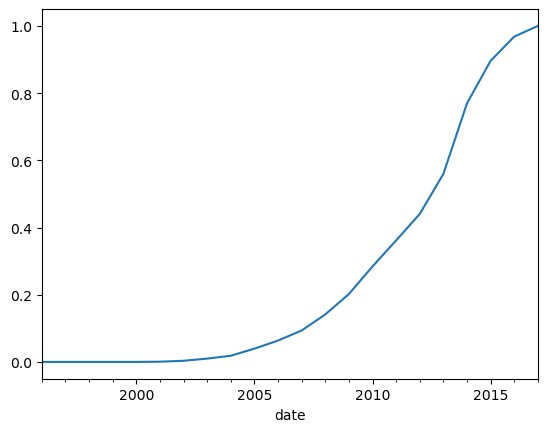

In [143]:
# Increase of number of US users through time.
# Je capte pas pourquoi il y a un message d'erreur ça me donne le cancer -> demander à tibo

df_us_users.loc[:,'date'] = pd.to_datetime(df_us_users['joined'].apply(lambda dt : datetime.datetime.fromtimestamp(dt).strftime('%Y-%m-%d')))
df_us_users.head(5)
df_users_year = df_us_users[['date','user_id']].groupby(pd.Grouper(freq = 'Y', key = 'date')).count()
df_users_year['cumulated'] = df_users_year['user_id'].cumsum().div(number_us_users)
df_users_year.cumulated.plot()

In [144]:
# 7 people joined before the ratings that we have? Who are they lol

joined_before = pd.to_datetime('2001-01-01')
us_users_joined = df_us_users[df_us_users.date < joined_before]
us_users_joined

,nbr_ratings,nbr_reviews,user_id,user_name,joined,location,date
42,1888,1887,beeradvocate.1,BeerAdvocate,840794400.0,"United States, Massachusetts",1996-08-23
163,4602,3561,jason.3,Jason,840794400.0,"United States, Massachusetts",1996-08-23
165,1699,1085,todd.2,Todd,840794400.0,"United States, California",1996-08-23
6498,18,16,javier.9,javier,977396400.0,"United States, Massachusetts",2000-12-21
18250,125,106,qxster1.12,QXSTER1,977742000.0,"United States, Pennsylvania",2000-12-25
23074,6,2,mevans05.6,mevans05,977310000.0,"United States, Massachusetts",2000-12-20
76584,1,0,mmakunas.10,mmakunas,977396400.0,"United States, California",2000-12-21


In [145]:
# Wow, we found the founders of Beer Advocate: the two brothers, Jason and Todd Alstrom!! xD xD xD xD xD XD XD XD XD
# Say HI to them!!

![alt text](./data/creators.jpeg "Title")

In [ ]:
# This also shows us that there are some organizations on the website! -> filtering must be done!!